In [2]:
import pandas as pd

df = pd.read_csv('admin.csv')
df.head()

,id,text,label,Comments
0,7789,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,NaN
1,7790,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,normal,NaN
2,7791,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,NaN
3,7792,"Finally I'm all caught up, and that sudden dea...",normal,NaN
4,7793,@carolinesinders @herecomesfran *hugs*,normal,NaN


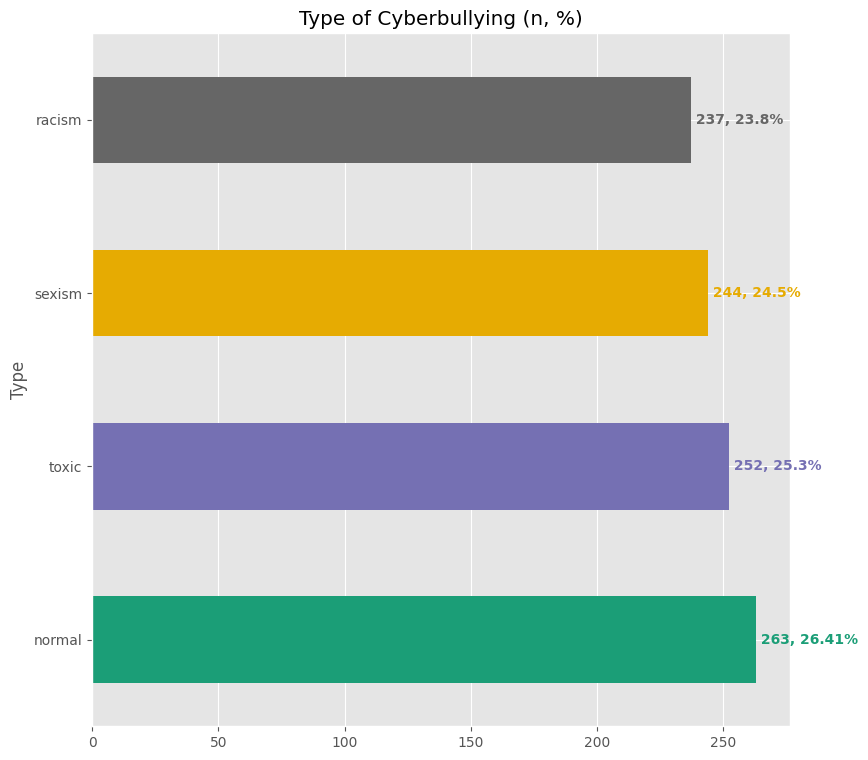

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(df["label"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df['label'].value_counts().plot.barh(title="Type of Cyberbullying (n, %)",
                                                 ylabel="Type",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df['label'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%",
           color=c,
           va='center',
           fontweight='bold')

In [4]:
df['Types'] = df['label'].map({'racism': 0,
                                            'sexism': 1,
                                            'toxic': 2,
                                            'normal': 3
                                            })

# drop unused column
df = df.drop(["label"], axis=1)

df.head()

,id,text,Comments,Types
0,7789,@AAlwuhaib1977 Muslim mob violence against Hin...,NaN,0
1,7790,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,NaN,3
2,7791,@jncatron @isra_jourisra @AMPalestine Islamoph...,NaN,0
3,7792,"Finally I'm all caught up, and that sudden dea...",NaN,3
4,7793,@carolinesinders @herecomesfran *hugs*,NaN,3


In [6]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [8]:
from sklearn.model_selection import train_test_split
y = tf.keras.utils.to_categorical(df["Types"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.25)

In [ ]:
!pip install tensorflow-text

In [10]:
import tensorflow_hub as hub
import tensorflow_text as text


In [11]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
bert_preprocess_model = hub.KerasLayer(preprocess_url)
bert_encoder_model = hub.KerasLayer(encoder_url)

In [ ]:
def get_embeddings(sentences):
    preprocessed_text = bert_preprocess_model(sentences)
    return bert_encoder_model(preprocessed_text)['pooled_output']

embeddings = get_embeddings([
    "Muslim mob violence against Hindus in Bangladesh continues in 2014."
    "Does N.e.bodyelse Hear her Crazy ass Screamin ,HOE, everytime she say's Stupid Hoe .. Lol. did n.e.body see Chris Browns face at 2:04 wen Nicki was touchin him If"
    "=stop ur stupid invlovment===="
    "We still do, as well as underestimating the judging #MKR"

])

print(embeddings)

In [15]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = cosine_similarity(features)
  fig = plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues",
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

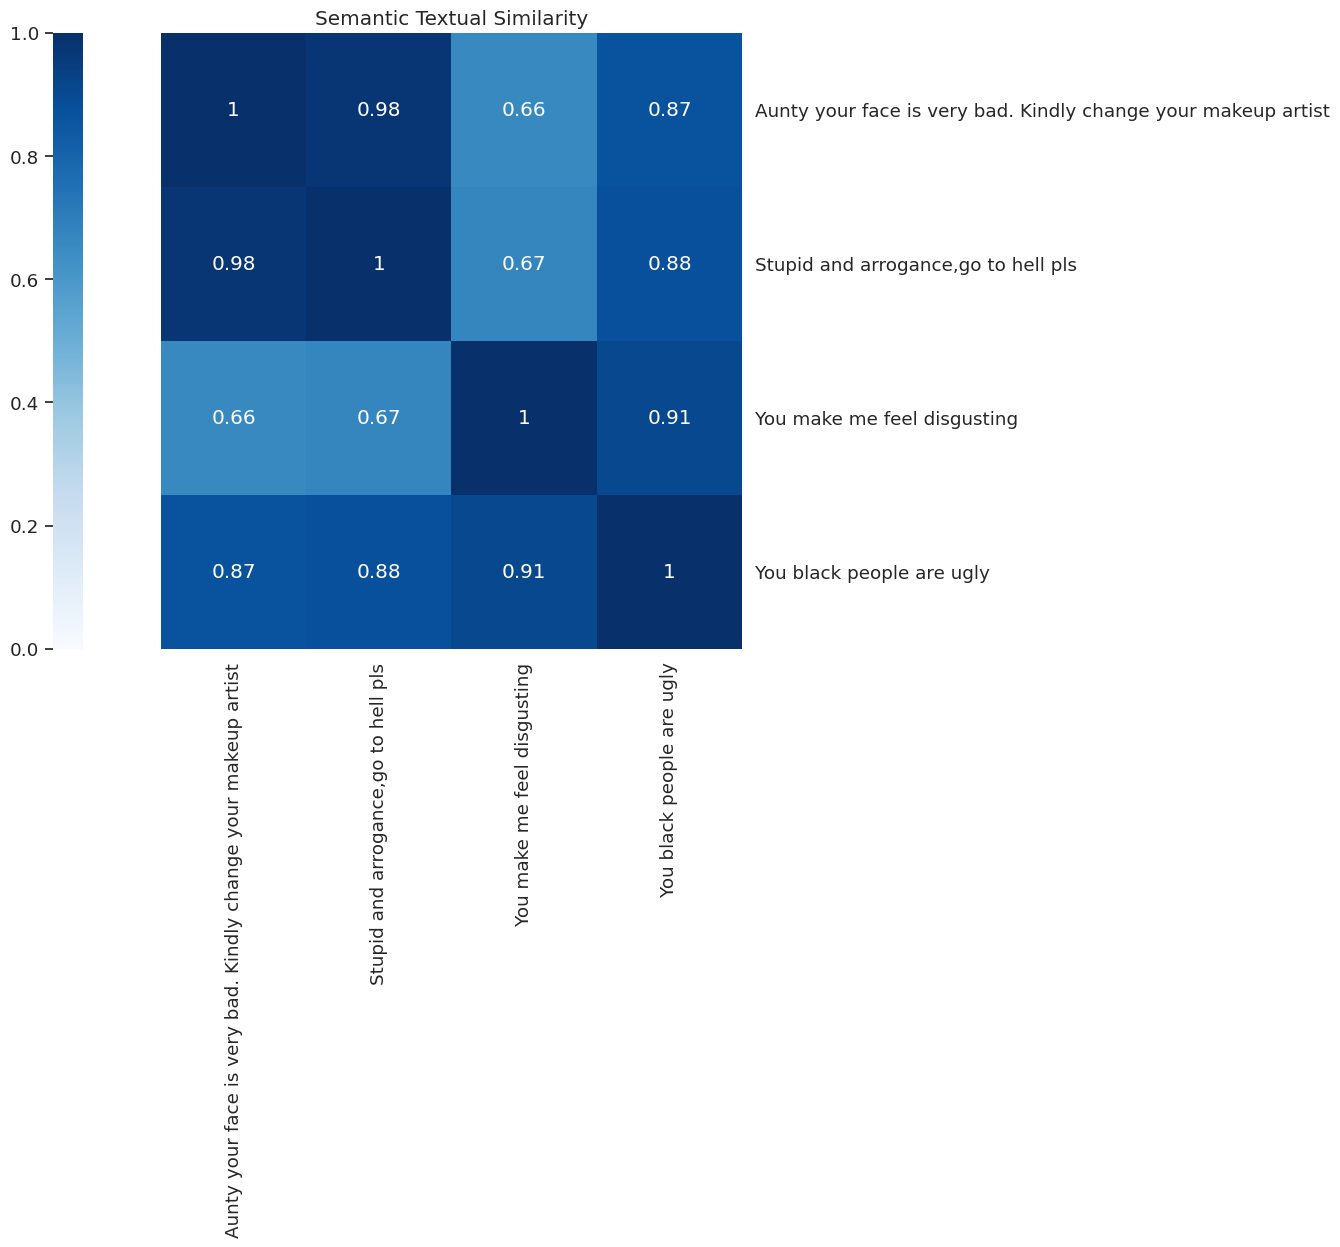

In [16]:
cmnts = [
    'Aunty your face is very bad. Kindly change your makeup artist',
    'Stupid and arrogance,go to hell pls',
    'You make me feel disgusting',
    'You black people are ugly'

]
plot_similarity(get_embeddings(cmnts), cmnts)

In [17]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):

    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):

    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [18]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = bert_preprocess_model(i)
x = bert_encoder_model(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [19]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train,
                      y_train,
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
24/24 [==============================] - 25s 519ms/step - loss: 1.4000 - accuracy: 0.3695 - balanced_recall: 0.1918 - balanced_precision: 0.2576 - balanced_f1_score: 0.2047 - val_loss: 1.1874 - val_accuracy: 0.4699 - val_balanced_recall: 0.1403 - val_balanced_precision: 0.3169 - val_balanced_f1_score: 0.1899
Epoch 2/20
24/24 [==============================] - 11s 455ms/step - loss: 1.1810 - accuracy: 0.4565 - balanced_recall: 0.2623 - balanced_precision: 0.4215 - balanced_f1_score: 0.3145 - val_loss: 1.1202 - val_accuracy: 0.4900 - val_balanced_recall: 0.2644 - val_balanced_precision: 0.3814 - val_balanced_f1_score: 0.3057
Epoch 3/20
24/24 [==============================] - 13s 568ms/step - loss: 1.1422 - accuracy: 0.4926 - balanced_recall: 0.2593 - balanced_precision: 0.4077 - balanced_f1_score: 0.3100 - val_loss: 1.0640 - val_accuracy: 0.5261 - val_balanced_recall: 0.2726 - val_balanced_precision: 0.5719 - val_balanced_f1_score: 0.3657
Epoch 4/20
24/24 [===================

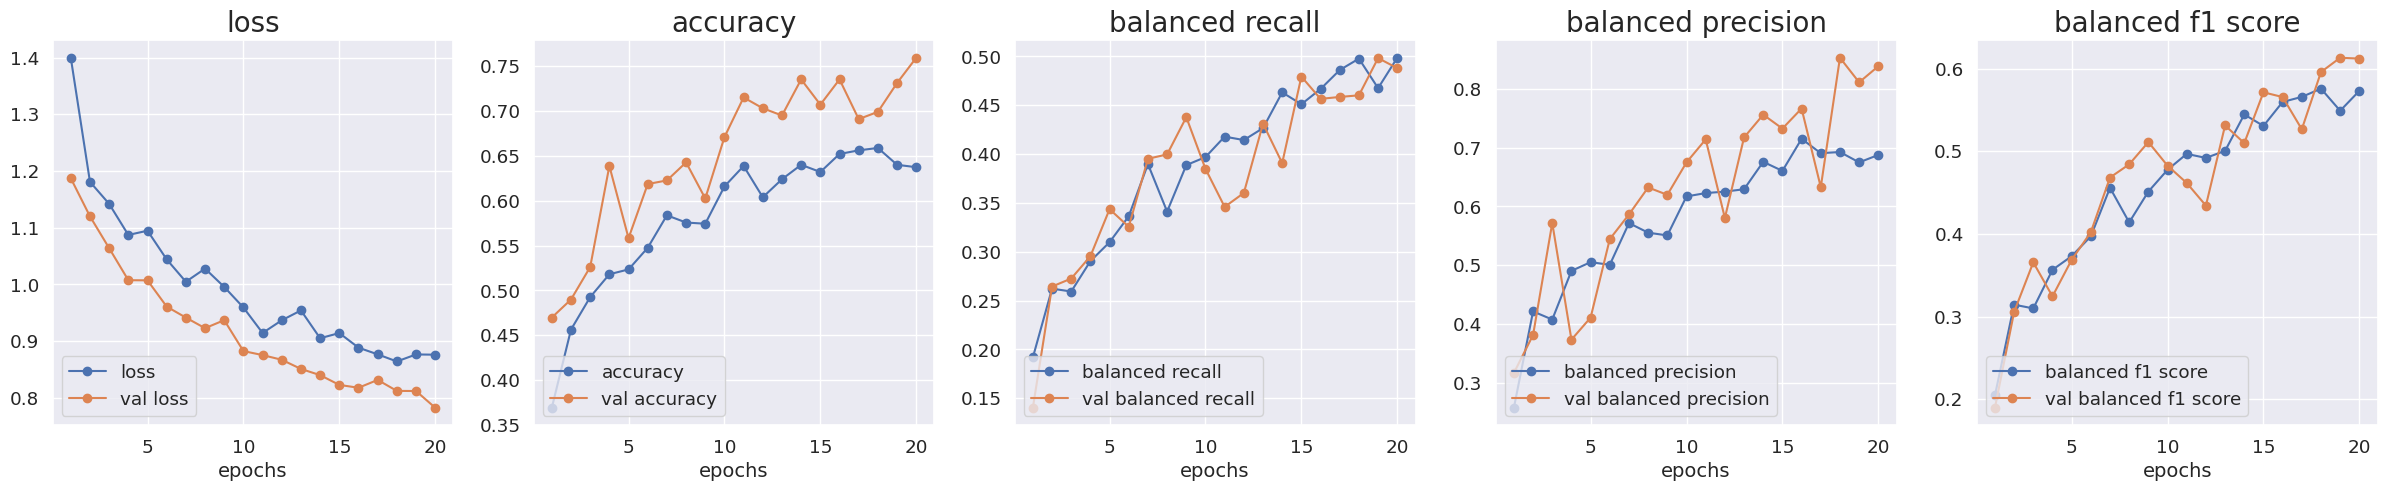

In [20]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [25]:
comments = [
    "You make me feel disgusting",
    "She is so ugly. I don't like her face",
    "Go kill yourself.",
    "You are pretty"

]


In [26]:
def predict_class(comments):
    predicted_probabilities = model.predict(comments)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    return predicted_classes


predicted_classes = predict_class(comments)
print(predicted_classes)

1/1 [==============================] - 0s 86ms/step
[2 1 3 2]


In [27]:
y_predicted_probabilities = model.predict(x_test)
y_predicted_classes = np.argmax(y_predicted_probabilities, axis=1)

8/8 [==============================] - 4s 327ms/step


In [28]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(np.argmax(y_test, axis=1), y_predicted_classes)
classification_rep = classification_report(np.argmax(y_test, axis=1), y_predicted_classes)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_rep)

Confusion Matrix:
[[47  3  1  2]
 [ 3 45  0 13]
 [ 1  2 54 10]
 [ 4  9 12 43]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        53
           1       0.76      0.74      0.75        61
           2       0.81      0.81      0.81        67
           3       0.63      0.63      0.63        68

    accuracy                           0.76       249
   macro avg       0.76      0.77      0.76       249
weighted avg       0.76      0.76      0.76       249



Text(43.25, 0.5, 'Truth')

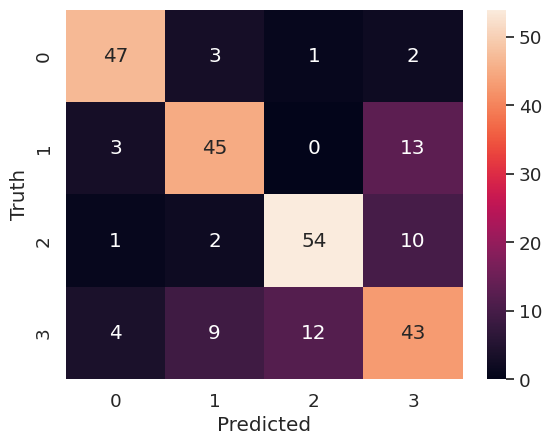

In [29]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')